In [45]:
import numpy as np
import pandas as pd
from sklearn.utils.validation import check_is_fitted
from sklearn.tree import DecisionTreeClassifier, plot_tree
from category_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

In [46]:
import sqlite3
from sql import run
run.prettytable.__dict__.setdefault('DEFAULT', run.prettytable.DEFAULT)

<TableStyle.DEFAULT: 10>

In [47]:
df = pd.read_csv("cleaned_nepal_earthquake.csv")

In [48]:
def wrangle(db_path):
    conn = sqlite3.connect(db_path)

    query= '''
    select distinct(id_map.building_id) as b_id, building_structure.*, building_damage.damage_grade
    from id_map
    join building_structure on id_map.building_id = building_structure.building_id
    join building_damage on id_map.building_id = building_damage.building_id
    where id_map.district_id = 36
    '''

    df = pd.read_sql(query, conn, index_col='b_id')

    drop_cols = [col for col in df.columns if 'post_eq' in col]

    df['damage_grade'] = df['damage_grade'].str[-1].astype(int)
    df['severe_damage'] = (df['damage_grade']>3).astype(int)

    drop_cols.append('damage_grade')

    correlation = df.select_dtypes('number').corr()

    df.drop(columns=drop_cols, inplace=True)
    return df

In [49]:
df = wrangle("/Users/mac/Desktop/venv/Gomycode/nepal_eq.db")

In [50]:
foundation_pivot = pd.pivot_table(
    df, index='foundation_type', values='severe_damage', aggfunc='mean').sort_values(by='severe_damage')
foundation_pivot

,severe_damage
foundation_type,
RC,0.027134
Bamboo/Timber,0.321429
Cement-Stone/Brick,0.410200
Mud mortar-Stone/Brick,0.684101
Other,0.801020


In [51]:
majority_class_prop, minority_class_prop =df['severe_damage'].value_counts(normalize=True)

In [52]:
target = 'severe_damage'
feature = df.drop('severe_damage', axis=1)
X = feature
y = df[target]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [54]:
model = Pipeline([
    ('ohe', OneHotEncoder(use_cat_names=True)),
    ('dtc', DecisionTreeClassifier())
])

In [55]:
model.fit(X_train, y_train)

Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['foundation_type', 'ground_floor_type',
                                     'land_surface_condition',
                                     'other_floor_type', 'plan_configuration',
                                     'position', 'roof_type',
                                     'superstructure'],
                               use_cat_names=True)),
                ('dtc', DecisionTreeClassifier())])

In [56]:
model.score(X_train, y_train)

0.9963976368497734

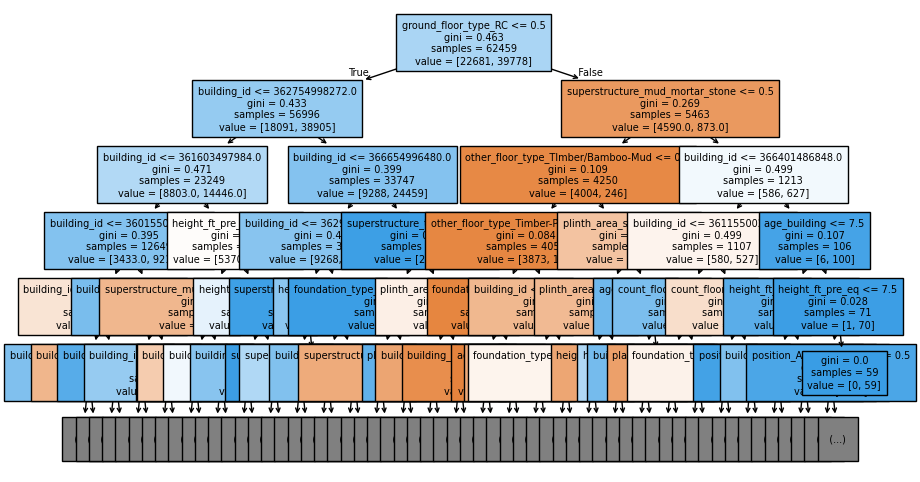

In [57]:
plt.figure(figsize=(10,6))
plot_tree(model.named_steps['dtc'], filled=True, 
          feature_names = model.named_steps['ohe'].get_feature_names_out(), max_depth=5, fontsize=7)
plt.show()

In [28]:
print(feature)

<bound method BaseEncoder.get_feature_names_out of OneHotEncoder(cols=['foundation_type', 'ground_floor_type',
                    'land_surface_condition', 'other_floor_type',
                    'plan_configuration', 'position', 'roof_type',
                    'superstructure'],
              use_cat_names=True)>


In [40]:
y_pred = model.predict(X_test)

In [44]:
print(f"Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7375600384245917
